<h1> Variational Auto Encoders </h1>

<h2> AutoEncoders </h2>

Autoencoders are special type of encoder decoder neural network where on one side you feed your data and on the other side you want to reconstruct the same data , in the middle you try to compress the data to a vector **z** where **len(z) << len(data)** . A typical autoencoder looks like this 

![autoencoder](https://wiki.tum.de/download/attachments/25007151/autoencoder_structure.png?version=2&modificationDate=1485704320100&api=v2)
![autoencoder](https://cdn-images-1.medium.com/max/703/0*yGqTBMopqHbR0fcF.)

This autoencoders are good for compression of data , but not in the case when we cant to generate new data from our training images or generate data which are completely new and never seen in the training examples , but somewhere related to our training images.

More formally we can define it as we want to build a generative model , which on trained on samples can learn and produce new samples which are from the training samples distribution, so our goal is to not only learn a netowork which can compress the training images and reconstruct it back but also which can learn the distribution which the training samples follow.

<h2> Variational Autoencoders </h2>

So in a variational autoencoder our task to is find out the distribution of our training samples and furthur produce samples from that distribution.

![image](https://camo.githubusercontent.com/74620840800d49e0e3f0fb97db950212f61ec596/687474703a2f2f6b766672616e732e636f6d2f636f6e74656e742f696d616765732f323031362f30382f7661652e6a7067)

Here we need to minimize two losses , One the **log liklihood loss** and the other is the **KL Divergence** , The first will ensure that we are able to reconstruct our training samples and the second ensures that we can find out the distribution of the training sample.

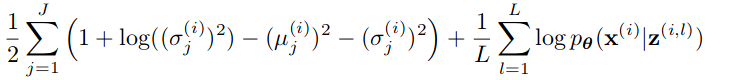

Here we use a CNN as an Encoder with layers and relu as activation and in Decoder we use Billinear Upsample. All the images are resized to 150x150.


# Results

## Reconstructions

#### Epoch 28
![recon](results/reconstruction_28.png)
#### Epoch 20
![recon](results/reconstruction_20.png)
#### Epoch 10
![recon](results/reconstruction_10.png)
#### Epoch 2
![recon](results/reconstruction_2.png)

## Generations

#### Epoch 28
![gen](results/sample_28.png)
#### Epoch 20
![gen](results/sample_20.png)
#### Epoch 10
![gen](results/sample_10.png)
#### Epoch 2
![gen](results/sample_2.png)

## Generation Epoch 1 to Epoch 28

![gen](results/generation.gif)

In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [10]:
batch_size=256
log_interval=10
CUDA_DEVICE=2

In [20]:
kwargs = {'num_workers': 1, 'pin_memory': True} 

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('data/celebA_data',
                   transform=transforms.Compose([
                       transforms.CenterCrop(150),
                       transforms.ToTensor()
                   ])),
                    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('data/test_celebA',
                   transform=transforms.Compose([
                       transforms.CenterCrop(150),
                       transforms.ToTensor()
                   ])),
                    batch_size=batch_size, shuffle=True, **kwargs)


In [22]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        self.cnv1=nn.Conv2d(3,10,3,2)
        self.cnv2=nn.Conv2d(10,3,4,2)
        self.fc1=nn.Linear(3*36*36,50)
        self.fc2=nn.Linear(3*36*36,50)
        self.fc3=nn.Linear(50,3*36*36)
        self.up2=nn.Upsample(scale_factor=2,mode='bilinear')
        self.pd2=nn.ReplicationPad2d(2)
        self.uc2=nn.Conv2d(3,10,3,1)
        self.up1=nn.Upsample(scale_factor=2,mode='bilinear')
        self.pd1=nn.ReplicationPad2d(2)
        self.uc1=nn.Conv2d(10,3,3,1)
        
        self.relu=nn.ReLU()
        self.sigmoid=nn.Sigmoid()

    
    def encode(self,x):
        h=self.relu(self.cnv1(x))
        h=self.relu(self.cnv2(h))
        h=h.view(-1,3*36*36)
        return self.fc1(h),self.fc2(h)
    
    def reparameterize(self,mean,logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mean)
        else:
            return mean
    
    def decode(self,x):
        x=self.fc3(x)
        x=x.view(-1,3,36,36)
        h=self.uc2(self.pd2(self.up2(x)))
        h=self.uc1(self.pd1(self.up1(h)))
        return self.sigmoid(h)
        

    def forward(self,im):
        mu,logvar=self.encode(im)
        z=self.reparameterize(mu,logvar)
        return self.decode(z),mu,logvar
    
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x,x,size_average=False)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data).cuda(CUDA_DEVICE)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    for i, (data, _) in enumerate(test_loader):
        data = data.cuda(CUDA_DEVICE)
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).data[0]
        if i == 0:
            n = min(data.size(0), 8)
            comparison = torch.cat([data[:n],recon_batch.view(batch_size, 3, 150, 150)[:n]])
            save_image(comparison.data.cpu(),
                     'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


    
    

ERROR! Session/line number was not unique in database. History logging moved to new session 42


In [23]:
model=VAE().cuda(CUDA_DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

for epoch in range(1, 50+ 1):
    train(epoch)
    test(epoch)
    sample = Variable(torch.randn(64, 50)).cuda(CUDA_DEVICE)
    sample = model.decode(sample).cpu()
    save_image(sample.data.view(64, 3, 150, 150),
'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/169999 (0%)]	Loss: 5952.119141


OSError: Traceback (most recent call last):
  File "/home/arijitx/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/arijitx/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 55, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/arijitx/.local/lib/python3.5/site-packages/torchvision/datasets/folder.py", line 122, in __getitem__
    img = self.loader(path)
  File "/home/arijitx/.local/lib/python3.5/site-packages/torchvision/datasets/folder.py", line 69, in default_loader
    return pil_loader(path)
  File "/home/arijitx/.local/lib/python3.5/site-packages/torchvision/datasets/folder.py", line 51, in pil_loader
    with Image.open(f) as img:
  File "/home/arijitx/.local/lib/python3.5/site-packages/PIL/Image.py", line 2585, in open
    % (filename if filename else fp))
OSError: cannot identify image file <_io.BufferedReader name='data/celebA_data/celebA/105852.jpg'>
